In [1]:
import os
import sys
import shutil
os.environ['TOKENIZERS_PARALLELISM'] = "False"
from glob import glob

import torch
import pandas as pd
import numpy as np
import json
from torch.nn.functional import cosine_similarity
from utils.video import read_frames_decord
from IPython.display import display, Markdown, Latex

import shared.utils as su
from notebooks.eval_care_retrieval import load_model

In [2]:
from models.modeling_encoders import AutoEncoder

# Load model
n_frames = 8
model_id = "/work/piyush/experiments/CaRe/Tarsier-7b/nli-9k+ego4d-1k/merged_checkpoint"
encoder = AutoEncoder.from_pretrained(model_id, device_map='auto')
su.misc.num_params(encoder.model)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading EncoderForTarsier from /work/piyush/experiments/CaRe/Tarsier-7b/nli-9k+ego4d-1k/merged_checkpoint
### do_image_padding is set as False, images will be resized directly!


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
TarsierForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
You are attempting to use Flash Attention 2.

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

::: Number of total parameters in TarsierForConditionalGeneration: 7063.427M


### Video classification

In [3]:
data_root = '/scratch/shared/beegfs/piyush/datasets/MMEB-V2'

meta_config = su.io.load_yml(
    '/users/piyush/projects/VLM2Vec/experiments/public/eval/video_cls.yaml'
)
meta_config['SmthSmthV2']

{'dataset_parser': 'ssv2',
 'dataset_name': 'SmthSmthV2',
 'video_root': 'video-tasks/videos/video_cls/SSv2',
 'frame_root': 'video-tasks/frames/video_cls/SSv2',
 'num_sample_per_subset': 1000,
 'max_frames_saved': 64,
 'num_frames': 8,
 'eval_type': 'local',
 'json_name': 'ssv2.jsonl'}

In [7]:
# Load video embeddings (should be pre-computed)
video_embs = torch.load(
    f"{data_root}/features/video_embeddings_mmebv2_video_cls.pt"
)
len(video_embs)

4430

In [45]:
def gather_text_embeddings(texts):
    ZT = {}
    for text in su.log.tqdm_iterator(texts, desc='Computing text embeddings'):
        with torch.no_grad():
            zt = encoder.encode_text(text)
            zt = torch.nn.functional.normalize(zt, dim=-1).squeeze(0).cpu().float()
        ZT[text] = zt
    return ZT

gather_text_embeddings(['sample sentence'] * 16).keys()

Computing text embeddings:   0%|          | 0/16 [00:00<?, ?it/s]

dict_keys(['sample sentence'])

In [48]:
meta_config.keys()

dict_keys(['SmthSmthV2', 'HMDB51', 'UCF101', 'K700', 'Breakfast'])

In [46]:
for ds_key in meta_config:
    su.log.print_update(f"Processing {ds_key}")
    d = meta_config[ds_key]
    eval_type = d['eval_type']
    data = su.io.load_jsonl(f"{data_root}/video-tasks/data/{d['json_name']}")
    data = pd.DataFrame(data)

    if eval_type == 'local':
        # Compute all text embeddings at once
        all_texts = np.unique(data.neg_text.sum())
        text_to_emb = gather_text_embeddings(all_texts)

        correct = []
        for j in su.log.tqdm_iterator(range(len(data)), desc='Gathering predictions'):
            row = data.iloc[j].to_dict()
            texts = row['neg_text']
            zt = torch.stack([text_to_emb[t] for t in texts])
            gt_index = texts.index(row['pos_text'])
            sim = video_embs[row['video_id']] @ zt.T
            pred_index = sim.argmax().item()
            correct.append(int(gt_index == pred_index))
        accuracy = np.mean(correct)
    else:
        continue

    su.log.print_update(f"")

Processing SmthSmthV2...........................................................  


Computing text embeddings:   0%|          | 0/18620 [00:00<?, ?it/s]

Gathering predictions:   0%|          | 0/1000 [00:00<?, ?it/s]

................................................................................  
Processing HMDB51...............................................................  
Processing UCF101...............................................................  
Processing K700.................................................................  
Processing Breakfast............................................................  


In [51]:
accuracies = {'SmthSmthV2': 70.9}

In [74]:
for ds_key in ['HMDB51', 'UCF101', 'K700', 'Breakfast']:
    su.log.print_update(f"Processing {ds_key}")
    d = meta_config[ds_key]
    eval_type = d['eval_type']
    data = su.io.load_jsonl(f"{data_root}/video-tasks/data/{d['json_name']}")
    data = pd.DataFrame(data)
    print("Number of rows: ", len(data))

    # Only keep those rows for which video embedding texts
    data = data[data.video_id.apply(lambda x: x in set(video_embs))]
    print("Number of rows after filtering: ", len(data))

    zv = torch.stack([video_embs[c] for c in data.video_id.tolist()])
    texts_local = data.pos_text.unique()
    text_to_emb_local = gather_text_embeddings(texts_local)
    zt = torch.stack([text_to_emb_local[c] for c in data.pos_text.tolist()])

    sim = zv @ zt.T
    pred_indices = sim.argmax(dim=-1)
    pred_classes = [data.pos_text.tolist()[i] for i in pred_indices]
    accuracy = np.round((np.array(pred_classes) == np.array(data.pos_text)).mean() * 100, 2)
    accuracies[ds_key] = accuracy
    
    su.log.print_update(f"")

Processing HMDB51...............................................................  
Number of rows:  1000
Number of rows after filtering:  997


Computing text embeddings:   0%|          | 0/51 [00:00<?, ?it/s]

................................................................................  
Processing UCF101...............................................................  
Number of rows:  1000
Number of rows after filtering:  1000


Computing text embeddings:   0%|          | 0/101 [00:00<?, ?it/s]

................................................................................  
Processing K700.................................................................  
Number of rows:  1000
Number of rows after filtering:  1000


Computing text embeddings:   0%|          | 0/519 [00:00<?, ?it/s]

................................................................................  
Processing Breakfast............................................................  
Number of rows:  433
Number of rows after filtering:  433


Computing text embeddings:   0%|          | 0/10 [00:00<?, ?it/s]

................................................................................  


In [75]:
np.mean([v for k, v in accuracies.items()])

np.float64(62.37800000000001)

### Video retrieval

In [76]:
data_root = '/scratch/shared/beegfs/piyush/datasets/MMEB-V2'

meta_config = su.io.load_yml(
    '/users/piyush/projects/VLM2Vec/experiments/public/eval/video_ret.yaml'
)
meta_config

{'MSR-VTT': {'dataset_parser': 'msrvtt',
  'dataset_name': 'MSR-VTT',
  'video_root': 'video-tasks/videos/video_ret/MSR-VTT/',
  'frame_root': 'video-tasks/frames/video_ret/MSR-VTT/',
  'num_sample_per_subset': 'None',
  'max_frames_saved': 64,
  'num_frames': 8,
  'eval_type': 'global'},
 'MSVD': {'dataset_parser': 'msvd',
  'dataset_name': 'MSVD',
  'video_root': 'video-tasks/videos/video_ret/MSVD/',
  'frame_root': 'video-tasks/frames/video_ret/MSVD/',
  'num_sample_per_subset': 'None',
  'max_frames_saved': 64,
  'num_frames': 8,
  'eval_type': 'global'},
 'DiDeMo': {'dataset_parser': 'didemo',
  'dataset_name': 'DiDeMo',
  'video_root': 'video-tasks/videos/video_ret/DiDeMo/',
  'frame_root': 'video-tasks/frames/video_ret/DiDeMo/',
  'num_sample_per_subset': 'None',
  'max_frames_saved': 64,
  'num_frames': 8,
  'eval_type': 'global'},
 'YouCook2': {'dataset_parser': 'youcook2',
  'dataset_name': 'YouCook2',
  'video_root': 'video-tasks/videos/video_ret/YouCook2/',
  'frame_root': 

In [77]:
# Load video embeddings (should be pre-computed)
video_embs = torch.load(
    f"{data_root}/features/video_embeddings_mmebv2_video_ret.pt"
)
len(video_embs)

10331

In [103]:
# This defines the huggingface repo and subset for each dataset
# (repo, subset, split)
json_paths = {
    "MSR-VTT": ("VLM2Vec/MSR-VTT", "test_1k", "test"),
    "MSVD": ("VLM2Vec/MSVD", None, "test"),
    "DiDeMo": ("VLM2Vec/DiDeMo", None, "test"),
    # "YouCook2": ("VLM2Vec/YouCook2", None, "val"), # HF version compatibility issue
    "YouCook2": ("lmms-lab/YouCook2", None, "val"),
    "VATEX": ("VLM2Vec/VATEX", None, "test"),
}

video_id_extractor = {
    "MSR-VTT": lambda x: x['video_id'],
    "MSVD": lambda x: x['video_id'],
    "DiDeMo": lambda x: x['video'].split('/')[-1].split('.')[0],
    "YouCook2": lambda x: x["id"],
    "VATEX": lambda x: x['videoID'],
}

video_root = "/scratch/shared/beegfs/piyush/datasets/MMEB-V2/video-tasks/frames/data/ziyan/video_retrieval"

In [104]:
captions_extractor = {
    "MSR-VTT": lambda x: [x["caption"]],
    "MSVD": lambda x: x["caption"],
    "DiDeMo": lambda x: [x["caption"]],
    "YouCook2": lambda x: [x['sentence']],
    "VATEX": lambda x: x["enCap"],
}

In [106]:
from datasets import load_dataset


text_embeds = {}
for ds_key in meta_config:
    su.log.print_update(f"Processing {ds_key}")
    d = meta_config[ds_key]

    repo, subset, split = json_paths[ds_key]
    df = pd.DataFrame(load_dataset(repo, subset)[split])
    video_dir = f"{video_root}/{ds_key}/frames"
    video_ids = os.listdir(video_dir)
    assert len(video_ids) == len(df)
    df['video_id'] = df.apply(lambda x: video_id_extractor[ds_key](x), axis=1)

    print(json.dumps(df.iloc[0].to_dict(), indent=2))

    all_texts = [
        captions_extractor[ds_key](df.iloc[i].to_dict()) for i in range(len(df))
    ]
    all_texts = np.unique(np.concatenate(all_texts))
    print("Total number of next captions: ", len(all_texts))

    text_embeds[ds_key] = gather_text_embeddings(all_texts)

    su.log.print_update(f"")
len(text_embeds)

Processing MSR-VTT..............................................................  
{
  "video_id": "video7020",
  "video": "video7020.mp4",
  "caption": "a woman creating a fondant baby and flower",
  "source": "MSR-VTT",
  "category": 10,
  "url": "https://www.youtube.com/watch?v=4KRMJNBjrEs",
  "start time": 221.77,
  "end time": 233.08,
  "id": 7020
}
Total number of next captions:  995


Computing text embeddings:   0%|          | 0/995 [00:00<?, ?it/s]

................................................................................  
Processing MSVD.................................................................  
{
  "video_id": "fr9H1WLcF1A_256_261",
  "video": "fr9H1WLcF1A_256_261.avi",
  "caption": [
    "two young men are playing table tennis",
    "men are playing table tennis",
    "two men are playing table tennis",
    "two men are playing table tennis",
    "two men are playing a tabletennis",
    "a couple of people are playing a game of ping pong",
    "peoples are playing table tennis",
    "two men are playing pingpong",
    "two guys play table tennis",
    "two people are playing ping pong",
    "two boys are playing ping pong",
    "two men are playing ping pong",
    "the people played pingpong together",
    "the men are playing table tennis",
    "two people play pingpong",
    "two men are playing ping pong",
    "the couple played pingpong together",
    "the boys are playing",
    "two men are playing table te

Computing text embeddings:   0%|          | 0/22285 [00:00<?, ?it/s]

................................................................................  
Processing DiDeMo...............................................................  
{
  "video": "test/52198061@N00_4175539607_26669cd634.mp4",
  "caption": "we pan right off the mural and on to a building. the view changes from artwork to a building in this shot. the screen moves to something dark the camera pans from the end of the mural to another structure and then a building.",
  "source": "DiDeMo",
  "video_id": "52198061@N00_4175539607_26669cd634"
}
Total number of next captions:  1004


Computing text embeddings:   0%|          | 0/1004 [00:00<?, ?it/s]

................................................................................  
Processing YouCook2.............................................................  
{
  "id": "xHr8X2Wpmno_0",
  "video_url": "https://www.youtube.com/watch?v=xHr8X2Wpmno",
  "recipe_type": "226",
  "segment": [
    47.0,
    60.0
  ],
  "sentence": "pick the ends off the verdalago",
  "video_path": "val/xHr8X2Wpmno_0.mp4",
  "youtube_id": "xHr8X2Wpmno",
  "video_id": "xHr8X2Wpmno_0"
}
Total number of next captions:  3105


Computing text embeddings:   0%|          | 0/3105 [00:00<?, ?it/s]

................................................................................  
Processing VATEX................................................................  
{
  "videoID": "5-xGskbsBgI_000055_000065",
  "enCap": [
    "A young man is showing the polish, water. old soft cloth and brush needed to polish shoes with.",
    "A person is setting up a table to get get ready to shine boots",
    "A man is giving instructions on how to polish with a brush and polisher.",
    "A  guy is explaining the items you need to clean a pair of shoes.",
    "A young man is preparing to demonstrate how to shine shoes.",
    "A man picks up a can of shoe paste, a towel, and brush from a table.",
    "A man is explaining what you need in order to shine shoes.",
    "A man instructs people on how to properly polish a pair of boots.",
    "A man is showing the products he uses to clean and shine shoes.",
    "A man discusses polishing an old pair of boots with an old t-shirt and a brush."
  ],
  "vide

Computing text embeddings:   0%|          | 0/44780 [00:00<?, ?it/s]

................................................................................  


5

In [108]:
len(text_emb)

44780

In [164]:
ret_accs = {}
for ds_key in meta_config:
    su.log.print_update(f"Processing {ds_key}")
    d = meta_config[ds_key]

    repo, subset, split = json_paths[ds_key]
    df = pd.DataFrame(load_dataset(repo, subset)[split])
    video_dir = f"{video_root}/{ds_key}/frames"
    video_ids = os.listdir(video_dir)
    assert len(video_ids) == len(df)
    df['video_id'] = df.apply(lambda x: video_id_extractor[ds_key](x), axis=1)

    print(json.dumps(df.iloc[0].to_dict(), indent=2))

    all_texts = [
        captions_extractor[ds_key](df.iloc[i].to_dict()) for i in range(len(df))
    ]
    all_texts = np.unique(np.concatenate(all_texts))
    print("Total number of next captions: ", len(all_texts))
    text_emb = text_embeds[ds_key]

    zv = torch.stack([video_embs[c] for c in df.video_id.tolist()])
    zt = torch.stack([text_emb[t] for t in all_texts])

    sim = zv @ zt.T
    pred_indices = sim.argmax(dim=-1)
    pred_captions = np.array([all_texts[i] for i in pred_indices])
    actu_captions = [captions_extractor[ds_key](df.iloc[i].to_dict()) for i in range(len(df))]
    is_correct = [int(x in y) for x, y in zip(pred_captions, actu_captions)]
    accuracy = np.round(np.mean(is_correct) * 100., 2).item()
    ret_accs[ds_key] = accuracy

    # break

    su.log.print_update(f"")

Processing MSR-VTT..............................................................  
{
  "video_id": "video7020",
  "video": "video7020.mp4",
  "caption": "a woman creating a fondant baby and flower",
  "source": "MSR-VTT",
  "category": 10,
  "url": "https://www.youtube.com/watch?v=4KRMJNBjrEs",
  "start time": 221.77,
  "end time": 233.08,
  "id": 7020
}
Total number of next captions:  995
................................................................................  
Processing MSVD.................................................................  
{
  "video_id": "fr9H1WLcF1A_256_261",
  "video": "fr9H1WLcF1A_256_261.avi",
  "caption": [
    "two young men are playing table tennis",
    "men are playing table tennis",
    "two men are playing table tennis",
    "two men are playing table tennis",
    "two men are playing a tabletennis",
    "a couple of people are playing a game of ping pong",
    "peoples are playing table tennis",
    "two men are playing pingpong",
    "two guy

In [165]:
ret_accs

{'MSR-VTT': 36.9,
 'MSVD': 77.46,
 'DiDeMo': 36.06,
 'YouCook2': 10.92,
 'VATEX': 51.97}

In [166]:
mean_acc = np.mean([v for k, v in ret_accs.items()])
mean_acc

np.float64(42.66199999999999)

In [163]:
sim = zv @ zt.T
pred_indices = sim.argmax(dim=-1)
pred_captions = np.array([all_texts[i] for i in pred_indices])
actu_captions = [captions_extractor[ds_key](df.iloc[i].to_dict()) for i in range(len(df))]
is_correct = [int(x in y) for x, y in zip(pred_captions, actu_captions)]
accuracy = np.round(np.mean(is_correct) * 100., 2).item()
accuracy

36.9

**Just for debugging**

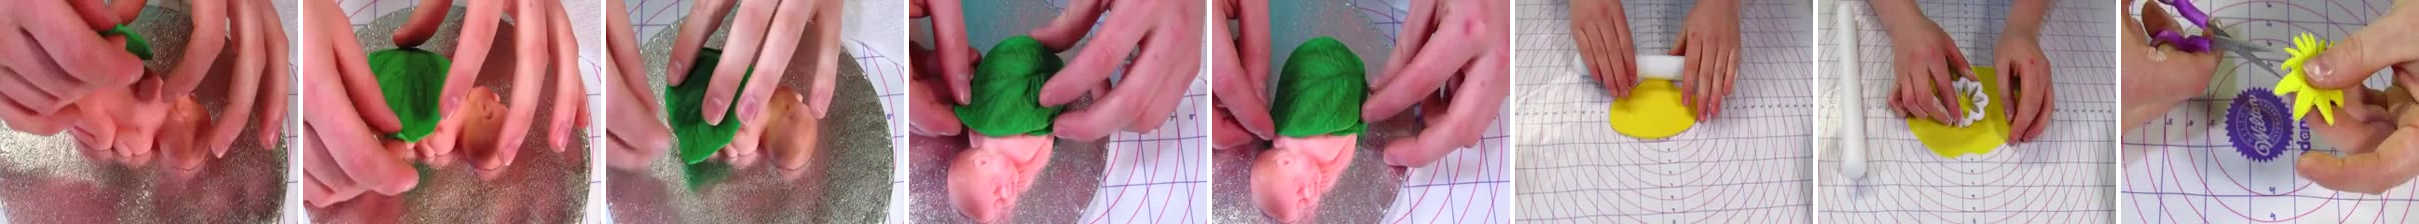

a woman creating a fondant baby and flower
['a woman creating a fondant baby and flower']


In [159]:
from natsort import natsorted
import PIL.Image

def show_frames_from_files(
        frame_dir, n_frames=8, sample='middle', fix_start=None, 
        max_num_frames=-1, trimmed30=False, height=-1, width=-1
    ):

    total_frames = len(os.listdir(frame_dir))
    indices = np.linspace(0, total_frames, n_frames, dtype=int, endpoint=False)

    files = np.array(natsorted(glob(f"{frame_dir}/*.*")))[indices]
    frames = [PIL.Image.open(f).convert("RGB") for f in files]
    display(su.visualize.concat_images_with_border(frames))

show_frames_from_files(os.path.join(video_dir, df.video_id[0]))
print(pred_captions[0])
print(actu_captions[0])

In [160]:
from collections import defaultdict
from utils.general_retrieval_metrics import itm_eval

img2txt = defaultdict(list)
txt2img = defaultdict(list)
for i in range(len(df)):
    row = df.iloc[i].to_dict()
    video_index = video_ids.index(row['video_id'])
    captions = captions_extractor[ds_key](row)
    captions_index = [list(all_texts).index(c) for c in captions]
    img2txt[video_index].extend(captions_index)
    for c in captions_index:
        txt2img[c].append(video_index)
len(img2txt), len(txt2img)

(1000, 995)

In [161]:
itm_eval(
    scores_t2i=(zt @ zv.T).numpy(),
    scores_i2t=(zv @ zt.T).numpy(),
    img2txt=img2txt,
    txt2img=txt2img,
)

{'txt_r1': np.float64(0.1),
 'txt_r5': np.float64(0.6),
 'txt_r10': np.float64(1.1),
 'txt_r_mean': np.float64(0.6),
 'img_r1': np.float64(0.0),
 'img_r5': np.float64(0.5025125628140703),
 'img_r10': np.float64(1.0050251256281406),
 'img_r_mean': np.float64(0.5025125628140703),
 'r_mean': np.float64(0.5512562814070352)}

In [123]:
txt2img

defaultdict(list,
            {446: [641],
             576: [399],
             688: [53],
             338: [132],
             228: [948],
             862: [266],
             246: [47],
             603: [347],
             694: [494],
             903: [537],
             198: [261],
             645: [113],
             146: [528],
             896: [525],
             674: [134],
             977: [138],
             42: [699],
             84: [7],
             241: [469],
             128: [102],
             744: [827],
             530: [98],
             727: [748],
             572: [415],
             44: [168],
             210: [83],
             585: [457],
             306: [371],
             815: [470],
             34: [531],
             563: [552],
             813: [597],
             131: [865],
             56: [883],
             392: [233],
             180: [638],
             41: [226],
             418: [620],
             381: [951],
             249: [

In [119]:
video_index, captions_index

(674, [528])

In [117]:
captions

['a yellow sports car with a guy speaking about the car']

In [ ]:
captions = 

In [110]:
zv.shape, zt.shape

(torch.Size([1000, 4096]), torch.Size([995, 4096]))

In [112]:
len(df.video_id.unique()) == len(df)

True

### Old code

In [17]:
dsname = os.path.basename(meta_config['SmthSmthV2']['frame_root'])
video_ids = os.listdir(f"{data_root}/video-tasks/frames/{dsname}/")
len(video_ids)

1000

In [35]:
from glob import glob 
from natsort import natsorted
import PIL.Image


def read_frames_from_files(
        frame_dir, n_frames=16, sample='middle', fix_start=None, 
        max_num_frames=-1, trimmed30=False, height=-1, width=-1
    ):

    total_frames = len(os.listdir(frame_dir))
    indices = np.linspace(0, total_frames, n_frames, dtype=int, endpoint=False)

    files = np.array(natsorted(glob(f"{frame_dir}/*.*")))[indices]
    frames = [PIL.Image.open(f).convert("RGB") for f in files]
    frames = torch.from_numpy(np.stack([np.asarray(x) for x in frames]))
    frames = frames.permute(0, 3, 1, 2)  # (T, C, H, W), torch.uint8
    return frames


frame_dir = f"{data_root}/video-tasks/frames/SSv2/231/"
video_tensor = read_frames_from_files(frame_dir)
video_tensor.shape

torch.Size([16, 3, 240, 427])

In [36]:
# Compute video embedding for a sample video
with torch.no_grad():
    zv = encoder.encode_vision(video_tensor.unsqueeze(0)).cpu().squeeze(0).float()
    zv = torch.nn.functional.normalize(zv, dim=-1)
zv.shape

torch.Size([4096])

**Compute embeddings for all videos together**

In [65]:
df_video = []
for ds_key in su.log.tqdm_iterator(meta_config, desc='Gathering video paths'):
    # dsname = os.path.basename(meta_config[ds_key]['frame_root'])

    file_name = meta_config[ds_key]['json_name']
    data_file = f'{data_root}/video-tasks/data/{file_name}'
    assert os.path.exists(data_file)
    data = su.io.load_jsonl(data_file)

    ds_name = os.path.basename(meta_config[ds_key]['frame_root'])
    for d in data:
        video_id = d['video_id']
        video_dir = f"{data_root}/video-tasks/frames/{ds_name}/{video_id}"
        assert os.path.isdir(video_dir)
        df_video.append(
            dict(ds_key=ds_key, ds_name=ds_name, video_id=video_id, video_dir=video_dir)
        )
df_video = pd.DataFrame(df_video)
df_video.shape

Gathering video paths:   0%|          | 0/5 [00:00<?, ?it/s]

(4433, 4)

In [66]:
df_video

,ds_key,ds_name,video_id,video_dir
0,SmthSmthV2,SSv2,231,/scratch/shared/beegfs/piyush/datasets/MMEB-V2...
1,SmthSmthV2,SSv2,476,/scratch/shared/beegfs/piyush/datasets/MMEB-V2...
2,SmthSmthV2,SSv2,1091,/scratch/shared/beegfs/piyush/datasets/MMEB-V2...
3,SmthSmthV2,SSv2,1481,/scratch/shared/beegfs/piyush/datasets/MMEB-V2...
4,SmthSmthV2,SSv2,1580,/scratch/shared/beegfs/piyush/datasets/MMEB-V2...
...,...,...,...,...
4428,Breakfast,Breakfast,P11_friedegg,/scratch/shared/beegfs/piyush/datasets/MMEB-V2...
4429,Breakfast,Breakfast,P20_sandwich,/scratch/shared/beegfs/piyush/datasets/MMEB-V2...
4430,Breakfast,Breakfast,P16_friedegg,/scratch/shared/beegfs/piyush/datasets/MMEB-V2...
4431,Breakfast,Breakfast,P19_salad,/scratch/shared/beegfs/piyush/datasets/MMEB-V2...


In [68]:
assert len(df_video.video_id.unique()) == len(df_video)

In [71]:
# # First, gather all video tensors
# video_tensors = {}
# for i in su.log.tqdm_iterator(range(len(df_video)), desc='Computing video embeddings'):
#     row = df_video.iloc[i].to_dict()
#     video_tensor = read_frames_from_files(row['video_dir'])
#     video_tensors[row['video_id']] = video_tensor
# len(video_tensors)

In [72]:
video_embeddings = {}
for i in su.log.tqdm_iterator(range(len(df_video)), desc='Computing video embeddings'):
    row = df_video.iloc[i].to_dict()
    video_tensor = read_frames_from_files(row['video_dir'])
    with torch.no_grad():
        zv = encoder.encode_vision(video_tensor.unsqueeze(0)).cpu().squeeze(0).float()
        zv = torch.nn.functional.normalize(zv, dim=-1)
    video_embeddings['video_id'] = zv
len(video_embeddings)

Computing video embeddings:   0%|          | 0/4433 [00:00<?, ?it/s]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
len(video_embeddings)

In [ ]:
for i in su.log.tqdm_iterator(range(len(video_embeddings), len(df_video)), desc='Computing video embeddings'):
    try:
        row = df_video.iloc[i].to_dict()
        video_tensor = read_frames_from_files(row['video_dir'])
        with torch.no_grad():
            zv = encoder.encode_vision(video_tensor.unsqueeze(0)).cpu().squeeze(0).float()
            zv = torch.nn.functional.normalize(zv, dim=-1)
        video_embeddings['video_id'] = zv
    except:
        print(f"Skip {i}.")
        continue
len(video_embeddings)

Computing video embeddings:   0%|          | 0/4432 [00:00<?, ?it/s]

Skip 9.
Skip 16.
Skip 17.
Skip 18.
Skip 19.
Skip 20.
Skip 21.
Skip 22.
Skip 23.
Skip 24.
Skip 25.
Skip 26.
Skip 27.
Skip 28.
Skip 29.
Skip 30.
Skip 31.
Skip 32.
Skip 33.
Skip 34.
Skip 35.
Skip 36.
Skip 37.
Skip 38.
Skip 39.
Skip 40.
Skip 41.
Skip 42.
Skip 43.
Skip 44.
Skip 45.
